[Github](https://github.com/trtd56/RFCX)

In [1]:
import pickle
import numpy as np
import pandas as pd
from IPython.display import Image

In [3]:
tp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_tp.csv')
fp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_fp.csv')

# Что такое псевдо-маркировка? [kaggle](https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969)

Псевдо-маркировка - это процесс добавления достоверно предсказанных тестовых данных к вашим обучающим данным. Псевдо-маркировка - это 5-шаговый процесс.
- (1) Постройте модель, используя данные обучения.
- (2) Предсказать метки для невидимого тестового набора данных.
- (3) Добавьте достоверные предсказанные тестовые наблюдения к нашим обучающим данным.
- (4) Создайте новую модель, используя комбинированные данные.
- (5) используйте вашу новую модель, чтобы спрогнозировать тестовые данные 

In [ ]:
with open('/content/drive/MyDrive/Rainforest/trtd56/exp0153_resnet18_focal_mixup_pseudo0.5_thr0.5.pkl', 'rb') as f:
    psedo_l = pickle.load(f)

pl = psedo_l['0099c367b_posi']
pl

array([[ 0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  1,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0]])

In [ ]:
tp[tp.recording_id == '0099c367b']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04


In [ ]:
fp[fp.recording_id == '0099c367b']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max



Обратите внимание, что _posi и _nega в конце не имеют ничего общего с фактическими положительными и отрицательными числами.
Как определить, откуда метка: tp_train или fp_train
Так что будьте осторожны, так как некоторые из них носятся (хорошо интегрируются при использовании)

Размер изображения 3751x128 пикселей, но он разделен на 512 окон.

Другими словами, каждый кадр соответствует фактическому размеру следующим образом.

Время пикселя кадра

    0 от 0 до 512 от 0 до 8
    1 463 ~ 975 7 ~ 15
    2 926 ~ 1438 14 ~ 23
    3 1389-1901 22-30
    4 1852 ~ 2364 29 ~ 37
    5 2315 ~ 2827 37 ~ 45
    6 2778-3290 44-52
    7 3241 ~ 3753 51 ~ 60


Положительная метка 1, когда  модель 3-5 fold будут иметь 0,5 или более.

Отрицательная метка -1, когда значение 0,01 или меньше.

Голоса с идентификатором разновидностей 17 появляются в интервале от 0 до 8 секунд и от 22 до 60 секунд.

In [ ]:
pl[:, 17]

array([1, 0, 0, 1, 1, 1, 1, 1])

В интервале от 22 до 30 секунд нет голосов с идентификатором вида 13 в интервале от 22 до 30 секунд.

In [ ]:
pl[:, 13]

array([ 0,  0,  0, -1,  0,  0,  0,  0])

# Pseudo

## v1

In [ ]:
EXP = "exp0127_resnet18_second_st_only_label_loss"
PSEUDO_THR = 0.9

all_fnames = tp_fnames+fp_fnames
train_datasets = SpectrogramFromNpz(all_fnames, "valid")

pseudo_label_dict_lst = []
for fold in range(5):
    print(f"### {fold} ###")
    model.load_state_dict(torch.load(f"{BEST_MODEL}/rfcxnet_f{fold}_best_score_model.bin"))

    pseudo_label_dict = {}
    for fname, (X, y, m) in tqdm.tqdm_notebook(zip(all_fnames, train_datasets), total=len(train_datasets)):
        labels = []
        for h, t in slide_img_pos:
            with torch.no_grad():
                outputs = model(X[:,:,h:t].unsqueeze(0).to(device))
            pred = outputs["clipwise_preds_att_ti"].sigmoid().cpu().numpy()[0]
            if sum(pred > PSEUDO_THR) > 0:
                idx = np.where(pred > PSEUDO_THR)
                _lab = np.eye(24)[idx[0]]
                _lab = (_lab.sum(0) > 0).astype(int)
            else:
                _lab = np.zeros(24)
            labels.append(_lab)
        labels = np.stack(labels).astype(int)
        if labels.sum() == 0:
            continue
        pseudo_label_dict[fname] = labels
    pseudo_label_dict_lst.append(pseudo_label_dict)

In [ ]:
pseudo_label_dict_5fold = {}
for fname in all_fnames:
    labels = []
    for pseudo_label_dict in pseudo_label_dict_lst:
        try:
            label = pseudo_label_dict[fname]
        except KeyError:
            label = np.zeros((8, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)
    if new_label.sum() == 0:
        continue
    pseudo_label_dict_5fold[fname] = new_label

## v2

In [ ]:
pseudo_label_dict_lst = []
for fold in range(5):
    print(f"### {fold} ###")
    model.load_state_dict(torch.load(f"{BEST_MODEL}/rfcxnet_f{fold}_best_score_model.bin"))
    model.eval()

    pseudo_label_dict = {}
    for fname, (X, y, m, _) in tqdm.tqdm_notebook(zip(all_fnames, train_datasets), total=len(train_datasets)):
        labels = []
        posi_labels, nega_labels = [], []
        for h, t in slide_img_pos:
            with torch.no_grad():
                outputs = model(X[:,:,h:t].unsqueeze(0).to(device))
            pred = outputs["clipwise_preds_att_ti"].sigmoid().cpu().numpy()[0]

            posi = (pred > PSEUDO_THR_P).astype(int)
            nega = (pred < PSEUDO_THR_N).astype(int) * -1
            posi_labels.append(posi)
            nega_labels.append(nega)

        #labels = np.stack(labels).astype(int)
        posi_labels = np.stack(posi_labels).astype(int)
        nega_labels = np.stack(nega_labels).astype(int)
        #if labels.sum() == 0:
        if posi_labels.sum() == 0 and nega_labels.sum() == 0:
            continue
        labels = np.stack([posi_labels, nega_labels])
        pseudo_label_dict[fname] = labels
    pseudo_label_dict_lst.append(pseudo_label_dict)

In [ ]:
pseudo_label_dict_5fold = {}
for fname in all_fnames:
    labels = []
    for pseudo_label_dict in pseudo_label_dict_lst:
        try:
            label = pseudo_label_dict[fname]
        except KeyError:
            label = np.zeros((8, 24))
        labels.append(label)

    #new_label = (np.stack(labels).sum(0) > 2).astype(int)
    posi_label, nega_label = np.stack(labels).sum(0)
    posi_label = (posi_label > 2).astype(int)
    nega_label = (nega_label < -2).astype(int) * -1
    new_label = posi_label + nega_label

    #if new_label.sum() == 0:
    if (new_label != 0).sum() == 0:
        continue
    pseudo_label_dict_5fold[fname] = new_label

# SED [kaggle](https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection)

Модель для задачи SED

Как мы можем обеспечить прогноз с информацией о времени начала и смещения? Для этого модели для задачи SED выводят посегментное прогнозирование вместо вывода агрегированного прогноза для клипа, который обычно используется для модели Audio Tagging.

Как мы можем выводить сегментный прогноз? Идея проста. 

Предположим, мы используем модель на основе 2D CNN, которая принимает журнал-мелспектрограмму в качестве входных данных и извлекает признаки с помощью экстрактора признаков CNN, а также выполняет классификацию с помощью карты признаков, которая является выводом CNN.

Вывод средства извлечения функций CNN по-прежнему содержит информацию о частоте и времени (он должен быть четырехмерным: 
    
    - размер пакета,
    - каналы,
    - частота,
    - время

поэтому, если мы агрегируем его только по оси частот, мы можем сохранить информацию о времени для этой функции. 

Эта карта функций содержит информацию о том, в каком временном отрезке какое звуковое событие произошло.

In [ ]:
Image(url = 'https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F113660%2F8798127d9151ea211837f69a51333181%2FSelection_100.png?generation=1597133890165201&alt=media')

In [ ]:
class ROI1(nn.Module):
    def forward(self, x):
        x  = torch.mean(x, dim=3)
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x  = x1 + x2
        return x

In [ ]:
Image(url = 'https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F113660%2F97695d9c9803d651b74276828b6ed012%2FSelection_103.png?generation=1597133890405225&alt=media' )

Следовательно, нам нужно обучать нашу модель SED без присмотра.

В настройках со слабым контролем у нас есть только аннотации на уровне клипа, поэтому нам также необходимо агрегировать их по оси времени.

Следовательно, мы сначала помещаем классификатор, который выводит вероятность существования класса для каждого временного шага сразу после экстрактора признаков, а затем агрегируем вывод результата классификатора на оси времени. 

Таким образом, мы можем получить как предсказание на уровне клипа, так и предсказание на уровне сегмента (если разрешение по времени высокое, его можно рассматривать как предсказание на уровне события).

Затем мы обучаем его обычным образом, используя потерю BCE с предсказанием на уровне клипа и аннотацией на уровне клипа.

In [ ]:
class Net:

    def __init__(self):
        super(Net, self).__init__()
        """        ...
        """
        self.roi = nn.Sequential(
                        ROI1(),
                        nn.Conv1d(2048, 2048, 1, bias=False),
                        nn.BatchNorm1d(2048),
                        nn.ReLU(inplace=True),
                        )
        
        self.probability = nn.Conv1d(2048, num_class, kernel_size=1, bias=False)
        self.attention = AttentPool(2048, num_class)

    def forward(self, x):
        """        ...
        """

        roi = self.roi(x)
        probability  = torch.sigmoid(self.probability(roi)) 
        attention = self.attention(roi) 
        pool = torch.sum(attention * probability, dim=2) 
        return pool, attention

In [ ]:
def interpolate(x: torch.Tensor, ratio: int):
    x = x.transpose(1, 2)
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    upsampled = upsampled.transpose(1, 2)
    return upsampled

class Net(nn.Module):
    def __init__(self, model_name):
        super(Net, self).__init__()
        self.n_label = 24

        base_model = timm.create_model(model_name, pretrained=True)
        h_idx, n_dense = MODEL_HEADER_INFO[model_name]        

        # self.model_head = nn.Sequential(*list(base_model.children())[:h_idx])
        self.resnet_head = nn.Sequential(*list(base_model.children())[:h_idx])
        self.fc_a = nn.Conv1d(n_dense, self.n_label, 1, bias=False)
        self.fc_b = nn.Conv1d(n_dense, self.n_label, 1, bias=False)

    def forward(self, x, perm=None, gamma=None):  # input x: (batch, channel, Hz, time)
        frames_num = x.shape[3]
        x = x.transpose(3, 2)  # (batch, channel, time, Hz)

        # h = self.model_head(x)  # (batch, unit, time, Hz)
        h = self.resnet_head(x)  # (batch, unit, time, Hz)

        if perm is not None:
            h = gamma * h + (1 - gamma) * h[perm]
            
        h = F.relu(h)
        ti_pool = torch.mean(h, dim=3)  # (batch, unit, time)

        xa = self.fc_a(ti_pool)  # (batch, n_class, time)
        xb = self.fc_b(ti_pool)  # (batch, n_class, time)
        xb = torch.softmax(xb, dim=2)

        # time pool
        pseudo_label_ti = (xa.sigmoid() >= 0.7).float()
        clipwise_preds_att_ti = torch.sum(xa * xb, dim=2)
        #clipwise_preds_max_ti, _ = torch.max(xa, dim=2)
        attention_preds_ti = xb
        segmentwise_output_ti = interpolate(xa, 32)

        return {
            "pseudo_label_ti": pseudo_label_ti,
            "clipwise_preds_att_ti": clipwise_preds_att_ti,
            "attention_preds_ti": attention_preds_ti,
            #"clipwise_preds_max_ti": clipwise_preds_max_ti,
            "segmentwise_output_ti": segmentwise_output_ti,
        }

def rfcx_criterion(outputs, targets, pseudo, b, perm):
    clipwise_preds_att_ti = outputs["clipwise_preds_att_ti"]
    #pseudo_label_ti = outputs["pseudo_label_ti"]
    #attention_preds_ti = outputs["attention_preds_ti"]

    posi_pseudo = (pseudo > 0).int().to(device)
    nega_pseudo = (pseudo < 0).int().to(device)

    #posi_label = ((targets == 1).sum(2) > 0).float().to(device)
    #posi_label = ((targets == 1).sum(2) + pseudo > 0).float().to(device)
    #nega_label = ((targets == -1).sum(2) > 0).float().to(device)

    posi_label = ((targets == 1).sum(2) + posi_pseudo).float().to(device)
    nega_label = ((targets == 1).sum(2) + nega_pseudo).float().to(device)

    posi_y = torch.ones(clipwise_preds_att_ti.shape).to(device)
    nega_y = torch.zeros(clipwise_preds_att_ti.shape).to(device)

    # mixup treat
    #posi_y = mixup(posi_y, b, perm)
    #nega_y = mixup(nega_y, b, perm)
    #posi_label = mixup(posi_label, b, perm)
    #nega_label = mixup(nega_label, b, perm)
    #posi_label = (posi_label > 0).float().to(device)
    #nega_label = (nega_label > 0).float().to(device)

    posi_loss = nn.BCEWithLogitsLoss(reduction="none")(clipwise_preds_att_ti, posi_y)
    nega_loss = nn.BCEWithLogitsLoss(reduction="none")(clipwise_preds_att_ti, nega_y)

    posi_loss = (posi_loss * posi_label).sum()
    nega_loss = (nega_loss * nega_label).sum()

    #att_loss = nn.BCEWithLogitsLoss()(attention_preds_ti, pseudo_label_ti)

    loss = posi_loss + nega_loss #+ att_loss*0.5

    return loss

# MIXUP [medium](https://medium.com/analytics-vidhya/better-result-with-mixup-at-final-layer-e9ba3a4a0c41)

MIXUP 
- это метод увеличения данных, предложенный Hongyi Zhang и др. 25 октября 2017 года. Основанный на соотношении смешивания, взятом из бета-распределения, это метод расширения данных путем смешивания входных и выходных данных. Говорят, что при его использовании улучшается производительность обобщения, поскольку граница решения становится гладкой.

-  Input Mixup (normal MIXUP) and Final Layer 
-  mixup_dataset
-  target mixup

In [ ]:
def mixup(input, gamma, perm):
    perm_input = input[perm]
    return input.mul_(gamma).add_(1 - gamma, perm_input)

In [ ]:
# model
# in forward
if perm is not None:
    h = gamma * h + (1 - gamma) * h[perm]

# train
"""
Распределение Дирихле является обобщением Бета-распределения на многомерный случай.
То есть, его функция плотности вероятности возвращает доверительную вероятность того, 
что вероятность каждого из K взаимоисключающих событий равна {\displaystyle x_{i}}x_{i} при условии, 
что каждое событие наблюдалось {\displaystyle \alpha _{i}-1}\alpha _{i}-1 раз.

"""
from numpy.random import beta
b = beta(0.1, 0.1)
perm = torch.randperm(_X.size(0))

"""
Возвращает случайную перестановку целых чисел от 0 до n - 1.
torch.randperm(4)
>> tensor([2, 1, 0, 3])

"""

outputs = model(_X, perm, b)
loss = rfcx_criterion(outputs, _y, b, perm)

def rfcx_criterion(outputs, targets, b=None, perm=None): #rfcx_3rd_criterion
    # ....

    # mixup treat
    posi_label = mixup(posi_label, b, perm)
    soft_posi_label = mixup(soft_posi_label, b, perm)
    #....

    return loss

# data magic


In [4]:
from tqdm import notebook

tp["type_value"] = 1  # Positive (TPs from data)
fp["type_value"] = -1  # False Positive (FP from the data)
train_all = pd.concat([tp, fp], axis=0).reset_index(drop=True)

npy = np.load('/content/drive/MyDrive/Rainforest/trtd56/00204008d.npy')
npy.shape

(128, 3751)

In [8]:
# split image(npy)
WINDOW = 256
N_SPLIT_IMG = 16
COVER = 23
N_LABEL = 24

slide_img_pos = [[0, WINDOW]]
for idx in range(1, N_SPLIT_IMG):
    h, t = slide_img_pos[idx-1][0], slide_img_pos[idx-1][1]
    h = t - COVER
    t = h + WINDOW
    slide_img_pos.append([h, t])

print("train slide_img_pos")
print(slide_img_pos[::5], len(slide_img_pos))

train slide_img_pos
[[0, 256], [1165, 1421], [2330, 2586], [3495, 3751]] 16


In [9]:
def _labeling(x):
    if x < 0.01:
        return -2  # difficult negative
    elif x < 0.5:
        return 0  # Don't know
    return 2  # Pseudo Positive

def _extract_seq_label(df):
    seq_label = np.zeros((N_LABEL, 3751))
    for species_id, t_min, f_min, t_max, f_max, type_value in df.values[:, [1, 3, 4, 5, 6, 7]]:
        h, t = int(3751*(t_min/60)), int(3751*(t_max/60))
        seq_label[species_id, h:t] = type_value
    return seq_label

def _put_soft_framewise_label(seq_label):
    soft_framewise_label = []
    for h, t in slide_img_pos:
        _posi = ((seq_label[:, h:t] == 1).sum(1) > 0).astype(int)
        _nega = ((seq_label[:, h:t] == -1).sum(1) > 0).astype(int)
        if ((_posi + _nega) > 1).sum() > 0:
            _nega = np.array([0 if _posi[i] == v == 1else v for i, v in enumerate(_nega)])
        _lab = _posi + _nega*-1
        soft_framewise_label.append(_lab)
    soft_framewise_label = np.stack(soft_framewise_label)
    return soft_framewise_label

def _merge_pseudo_labels(org_label, pseudo_label):
    lst = []
    for l1, l2 in zip(org_label, pseudo_label):
        org_zero_idx = np.where(l1 == 0)[0]
        l1[org_zero_idx] = l2[org_zero_idx]
        lst.append(l1)
    return np.array(lst)



for recording_id, org_df in notebook.tqdm(train_all.groupby("recording_id"), total=len(train_all["recording_id"].unique())):
    print(recording_id)
    seq_label = _extract_seq_label(org_df)
    soft_framewise_label = _put_soft_framewise_label(seq_label)
    break

00204008d


In [10]:
seq_label.shape

(24, 3751)

In [17]:
seq_label[4, 936:1054]

array([ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        0.])

In [19]:
fp[fp.recording_id == '00204008d']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,type_value
0,00204008d,21,1,13.8400,3281.25,14.9333,4125.00,-1
1,00204008d,8,1,24.4960,3750.00,28.6187,5531.25,-1
2,00204008d,4,1,15.0027,2343.75,16.8587,4218.75,-1


In [34]:
for t1, t2 in zip((13.8400, 24.4960, 15.0027), (14.9333,28.6187, 16.8587)):
    h, t = int(3751*(t1/60)), int(3751*(t2/60))
    print(h, t)


865 933
1531 1789
937 1053


seq_label

Так так я близо к разгадке этого шаманства

У нас 24 метки мы сделали метки тойже длины что и spec_npy в данном примере это фолс позитив и мы види что в одном файле есть 3 метки и мы заполняем -1 в тех местах по времени где указана конкретная песня

In [33]:
soft_framewise_label[:, [4, 8, 21]]

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [-1,  0, -1],
       [-1,  0, -1],
       [ 0,  0,  0],
       [ 0, -1,  0],
       [ 0, -1,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [31]:
slide_img_pos

[[0, 256],
 [233, 489],
 [466, 722],
 [699, 955],
 [932, 1188],
 [1165, 1421],
 [1398, 1654],
 [1631, 1887],
 [1864, 2120],
 [2097, 2353],
 [2330, 2586],
 [2563, 2819],
 [2796, 3052],
 [3029, 3285],
 [3262, 3518],
 [3495, 3751]]

soft_framewise_label

Мы нарезаем изображение на окна и соответственно нам нужны метки для каждого окна.
- почему две метки это начало и конец диапазона
- почему одинаковые 4 и 21 ну диапазон примерно похож

In [38]:
import random

def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


class TimeMask:
    def __init__(self, T=40, num_masks=1, replace_with_zero=True):
        self.T = T
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.copy()
        print(cloned.shape)
        len_spectro = cloned.shape[2]
    
        for i in range(0, self.num_masks):
            print(self.T)
            t = random.randrange(0, self.T)
            t_zero = random.randrange(0, len_spectro - t)


            if (t_zero == t_zero + t): return cloned

            mask_end = random.randrange(t_zero, t_zero + t)
            if (self.replace_with_zero): cloned[:,:,t_zero:mask_end] = 0
            else: cloned[:,:,t_zero:mask_end] = cloned.mean()
        return cloned

class FreqMask:
    def __init__(self, F=30, num_masks=1, replace_with_zero=True):
        self.F = F
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.copy()
        num_mel_channels = cloned.shape[1]
    
        for i in range(0, self.num_masks):        
            f = random.randrange(0, self.F)
            f_zero = random.randrange(0, num_mel_channels - f)

          
            if (f_zero == f_zero + f): return cloned

            mask_end = random.randrange(f_zero, f_zero + f) 
            if (self.replace_with_zero): cloned[:, f_zero:mask_end] = 0
            else: cloned[:, f_zero:mask_end] = cloned.mean()
    
        return cloned

In [114]:
import matplotlib.pyplot as plt
a = mono_to_color(npy)

In [119]:
# FreqMask
cloned = a.copy()
cloned = cloned.reshape(3, 128, 3751)
F = 70
num_mel_channels = cloned.shape[1]   
f = random.randrange(0, F)
print(f)
f_zero = random.randrange(0, num_mel_channels - f)
print(f_zero)


mask_end = random.randrange(f_zero, f_zero + f) 
cloned[:, f_zero:mask_end] = 0

10
76


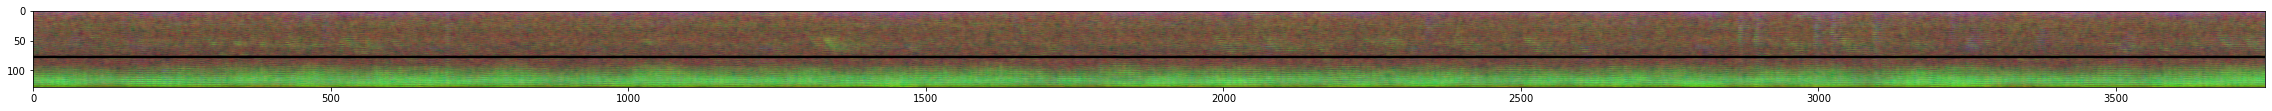

In [120]:
plt.figure(figsize=(40, 400))
plt.imshow(np.transpose(cloned, (1,2,0)))

In [ ]:
cloned[:, f_zero:mask_end] = cloned.mean()

In [124]:
# TimeMask

T=1080
cloned = a.copy()
cloned = cloned.reshape(3, 128, 3751)
len_spectro = cloned.shape[2]   
f = random.randrange(0, T)
print(f)
t_zero = random.randrange(0, len_spectro -f)
print(t_zero)


mask_end = random.randrange(f_zero, f_zero + f) 
cloned[:,:,t_zero:mask_end] = 0            

980
434


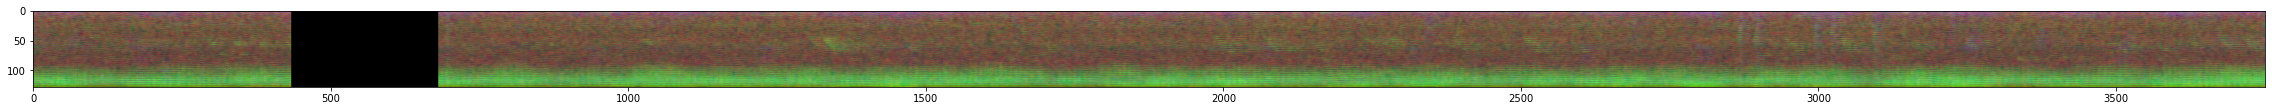

In [125]:
plt.figure(figsize=(40, 400))
plt.imshow(np.transpose(cloned, (1,2,0)))

In [127]:
a.shape, cloned.shape

((128, 3751, 3), (3, 128, 3751))